用pinns求解泊松方程 $-\triangle u = f$，这里$u = sin(x)sin(y)$，限定区域$\Omega = [0,1]^2$。

## 第一步先生成数据集
- 均匀分布
- 数据集大小：$256\times 256$

In [2]:
# 需要用的依赖包
import math

import torch as torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict


# 设置精度
torch.set_printoptions(precision=9)
torch.set_default_dtype(torch.double)

In [3]:
def u_exact(x,y):
    return torch.sin(x)*torch.cos(y)
def f(x,y):
    return 2*torch.sin(x)*torch.cos(y)

x = torch.arange(0,1+0.01,0.01) #arange 取头不取尾，故在尾部加上步长。共取101*101个点。默认是列向量。
y = torch.arange(0,1+0.01,0.01)
N = 101*101
print(x.size())
X,Y = torch.meshgrid(x,y)
print(X.size())

# 生成均匀的区域内部取样点
XY_in = torch.stack((torch.flatten(X[1:-1,1:-1]),torch.flatten(Y[1:-1,1:-1])),dim=1)
print(XY_in)
# 生成均匀的边界取样点
X0Y = torch.stack((X[0,:],Y[0,:]),dim=1)
X1Y = torch.stack((X[-1,:],Y[0,:]),dim=1)
XY0 = torch.stack((X[:,0],Y[:,0]),dim=1)
XY1 = torch.stack((X[:,0],Y[:,-1]),dim=1)

# print(XY_in)
# print(X0Y)

# 拼接成一个二维张量，前249*249个是内部的采样点，后面的是边界采样点。
XY = torch.cat((XY_in,X0Y,X1Y,XY0,XY1),0)

# 带入u_exact求值
u = u_exact(XY[:,0],XY[:,1])
#u = torch.zeros(N+4)
#for i in range(N+4):
#    u[i] = u_exact(XY[i][0],XY[i][1])
U = u[:,None]
XYU = torch.cat((XY,U),1)
print(XYU.shape)

torch.Size([101])
torch.Size([101, 101])
tensor([[0.010000000, 0.010000000],
        [0.010000000, 0.020000000],
        [0.010000000, 0.030000000],
        ...,
        [0.990000000, 0.970000000],
        [0.990000000, 0.980000000],
        [0.990000000, 0.990000000]])
torch.Size([10205, 3])


c:\Users\kl869\.conda\envs\pytorch-3060\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 设置模型参数
- layers : 5
- 
## 定义了'Model'
- layers
- size
- 每层的模型
- forward

In [4]:
class TestModel(nn.Module):
    def __init__(self,input_size=2,hidden_size=20,output_size=1,activation=torch.nn.Tanh(),layers=5):
        """
        input_size = 2
        hidden_size = 20
        output_size = 1
        layers = 5
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = layers
        self.act = activation
        Layers = [("input",nn.Linear(self.input_size,self.hidden_size))]
        Layers.append(("input_act",self.act))

        for i in range(layers-1):
            Layers.append((f"hidden_{i}",nn.Linear(self.hidden_size,self.hidden_size)))
            Layers.append((f"hidden{i}",self.act))
        
        Layers.append((f"output_{i}",nn.Linear(self.hidden_size,self.output_size)))

        LayersDict = OrderedDict(Layers)

        self.Layers = nn.Sequential(LayersDict)
    
    def forward(self,x):# 重写了父类nn.Module中的forward方法，nn.Module中还有__call__()方法，可以调用forward。
        return self.Layers(x)


## 定义Net类
其中包括
- loss

In [5]:
class Net:
    def __init__(self,XY=XY,XYU=XYU,batch_size=256,epochs=1,device=torch.device("cuda"),alpha=1):
        """
        此Net中，模型和优化算法都未提供接口。
        """
        self.device = device

        self.XY = XY.clone().detach().to(self.device)
        self.XYU = XYU.clone().detach().to(self.device)
        self.XY.requires_grad_()

        self.batch_size = batch_size
        self.epochs = epochs
        self.a = alpha # a 是损失函数中边界误差的权重系数
        self.N = self.XY.shape[0] # 总共输入的数据点数量

        # self.N_in =

        self.model = TestModel(input_size=2,hidden_size=20,output_size=1,activation=nn.Tanh(),layers=5).to(self.device) # 模型初始化的时候就指定设备
        
        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.iter = 1 # 迭代次数
        self.Loss = -1

    def u_exact(self,x,y):
        return torch.sin(x)*torch.cos(y)
    def f(self,x,y):
        return 2*torch.sin(x)*torch.cos(y)
    

    def LossFunc(self):
        self.optimizer.zero_grad()

        u = self.model(self.XY)# 默认调用了forward，得到了 u 的训练值，而非真实值。
        u_XY = torch.autograd.grad(inputs = self.XY,outputs = u,grad_outputs = torch.ones_like(self.model(self.XY)),retain_graph = True,create_graph = True)[0]
        u_x = u_XY[:,0]
        u_y = u_XY[:,1]
        u_x_XY = torch.autograd.grad(inputs = self.XY,outputs = u_x,grad_outputs = torch.ones_like(u_x),retain_graph = True,create_graph = True)[0]
        u_y_XY = torch.autograd.grad(inputs = self.XY,outputs = u_y,grad_outputs = torch.ones_like(u_y),retain_graph = True,create_graph = True)[0]
        
        u_xx = u_x_XY[0:9801,0]
        u_yy = u_y_XY[0:9801,1]
        f = self.f(self.XY[0:9801,0],self.XY[0:9801,1])

        # 如果用for循环，则完全未用到gpu的速度优势。
        #for i in range(62001):
        #    f[i] = u_exact(XY[i,0],XY[i,1])
        
        xy_bound = self.XY.clone().detach()[9801::,:].to(self.device)

        u_bound = self.model(xy_bound)
        g = self.XYU[9801::,2]
        loss = nn.MSELoss()(-u_xx-u_yy,f) + nn.MSELoss()(u_bound,g) # 括号内每一个变量都为向量

        self.Loss = loss.item()

        loss.backward()

        return loss

    def train(self): # train 模块要包括可视化(作图，进度条...)。
        for i in range(1000):
            self.optimizer.step(self.LossFunc) # 一般不带括号，step中会带括号
            if((i+1)%100==0):
                print(f"第{i+1}次迭代，误差为{self.Loss}")
        

In [6]:
net = Net()
net.train()

c:\Users\kl869\.conda\envs\pytorch-3060\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([404])) that is different to the input size (torch.Size([404, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第100次迭代，误差为0.13349111187271137
第200次迭代，误差为0.09659682771589663
第300次迭代，误差为0.09412202776362862
第400次迭代，误差为0.09329529022085359
第500次迭代，误差为0.0928847237597049
第600次迭代，误差为0.09263060560352401
第700次迭代，误差为0.09245804599210672
第800次迭代，误差为0.09233801926432082
第900次迭代，误差为0.09225480427005904
第1000次迭代，误差为0.09219805996971397


作图

In [7]:
X, Y = np.meshgrid(np.linspace(-3, 3, 3), np.linspace(-3, 3, 3))#默认是行向量
print(X,Y)

[[-3.  0.  3.]
 [-3.  0.  3.]
 [-3.  0.  3.]] [[-3. -3. -3.]
 [ 0.  0.  0.]
 [ 3.  3.  3.]]


In [8]:
import matplotlib.pyplot as plt

In [9]:
x = torch.arange(0,1+0.05,0.05)
y = torch.arange(0,1+0.05,0.05)
X,Y = torch.meshgrid([x,y])
XY = torch.stack([X.flatten(),Y.flatten()],dim=1).to(net.device)
net.model.eval()
with torch.no_grad():
    u_pred = net.model(XY)
X = X.detach().to('cpu').numpy()
Y = Y.detach().to('cpu').numpy()
u_pred = u_pred.detach().to('cpu').numpy().reshape(X.shape[0],X.shape[0])

Text(0.5, 1.0, 'Heatmap(predict)')

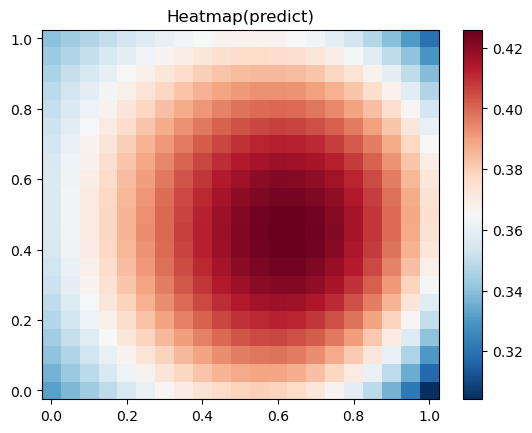

In [10]:
# 画一个heatmap
fig, ax = plt.subplots()
pc = ax.pcolormesh(X,Y,u_pred,cmap = 'RdBu_r')
fig.colorbar(pc,ax = ax)
ax.set_title("Heatmap(predict)")